## DYNAMIC PRICING

In [2]:
pip install catboost

#### references 
###### https://www.altexsoft.com/blog/dynamic-pricing-explained-use-in-revenue-management-and-pricing-optimization/

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import dill

# Metrics
import math
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score

# Regression Algorithms
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

warnings.filterwarnings('ignore') 


In [5]:
df = pd.read_csv('dynamic_pricing.csv')  

In [6]:
df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


In [8]:
num=df.select_dtypes(include='number')
num

,Number_of_Riders,Number_of_Drivers,Number_of_Past_Rides,Average_Ratings,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,13,4.47,90,284.257273
1,58,39,72,4.06,43,173.874753
2,42,31,0,3.99,76,329.795469
3,89,28,67,4.31,134,470.201232
4,78,22,74,3.77,149,579.681422
...,...,...,...,...,...,...
995,33,23,24,4.21,11,91.389526
996,84,29,92,4.55,94,424.155987
997,44,6,80,4.13,40,157.364830
998,53,27,78,3.63,58,279.095048


In [9]:
cat=df.select_dtypes(exclude='number')

In [10]:
cat

,Location_Category,Customer_Loyalty_Status,Time_of_Booking,Vehicle_Type
0,Urban,Silver,Night,Premium
1,Suburban,Silver,Evening,Economy
2,Rural,Silver,Afternoon,Premium
3,Rural,Regular,Afternoon,Premium
4,Rural,Regular,Afternoon,Economy
...,...,...,...,...
995,Urban,Gold,Morning,Premium
996,Urban,Regular,Morning,Premium
997,Suburban,Gold,Night,Premium
998,Suburban,Regular,Night,Premium


In [11]:
num.isnull().sum()

Number_of_Riders           0
Number_of_Drivers          0
Number_of_Past_Rides       0
Average_Ratings            0
Expected_Ride_Duration     0
Historical_Cost_of_Ride    0
dtype: int64

In [12]:
cat.isnull().sum()

Location_Category          0
Customer_Loyalty_Status    0
Time_of_Booking            0
Vehicle_Type               0
dtype: int64

In [13]:
# Print unique values for categorical columns
print("Categorical Columns:")
for col in cat.columns:
    print(f"{col}: {cat[col].nunique()} unique values")

# Print unique values for numerical columns
print("\nNumerical Columns:")
for col in num.columns:
    print(f"{col}: {num[col].nunique()} unique values")

Categorical Columns:
Location_Category: 3 unique values
Customer_Loyalty_Status: 3 unique values
Time_of_Booking: 4 unique values
Vehicle_Type: 2 unique values

Numerical Columns:
Number_of_Riders: 81 unique values
Number_of_Drivers: 79 unique values
Number_of_Past_Rides: 101 unique values
Average_Ratings: 151 unique values
Expected_Ride_Duration: 171 unique values
Historical_Cost_of_Ride: 1000 unique values


In [14]:
df.shape

(1000, 10)

#### Preprocessing

In [16]:
df.dtypes

Number_of_Riders             int64
Number_of_Drivers            int64
Location_Category           object
Customer_Loyalty_Status     object
Number_of_Past_Rides         int64
Average_Ratings            float64
Time_of_Booking             object
Vehicle_Type                object
Expected_Ride_Duration       int64
Historical_Cost_of_Ride    float64
dtype: object

In [17]:
df.duplicated().value_counts()

False    1000
Name: count, dtype: int64

In [18]:
print('the categorical columns are: ',cat.columns)
print('the numerical columns are :',num.columns)

the categorical columns are:  Index(['Location_Category', 'Customer_Loyalty_Status', 'Time_of_Booking',
       'Vehicle_Type'],
      dtype='object')
the numerical columns are : Index(['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides',
       'Average_Ratings', 'Expected_Ride_Duration', 'Historical_Cost_of_Ride'],
      dtype='object')


#### EDA

In [20]:
# summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Number_of_Riders,1000.0,60.372000,23.701506,20.000000,40.000000,60.000000,81.000000,100.000000
Number_of_Drivers,1000.0,27.076000,19.068346,5.000000,11.000000,22.000000,38.000000,89.000000
Number_of_Past_Rides,1000.0,50.031000,29.313774,0.000000,25.000000,51.000000,75.000000,100.000000
Average_Ratings,1000.0,4.257220,0.435781,3.500000,3.870000,4.270000,4.632500,5.000000
Expected_Ride_Duration,1000.0,99.588000,49.165450,10.000000,59.750000,102.000000,143.000000,180.000000
Historical_Cost_of_Ride,1000.0,372.502623,187.158756,25.993449,221.365202,362.019426,510.497504,836.116419


In [21]:
df.describe(include='object').T

,count,unique,top,freq
Location_Category,1000,3,Urban,346
Customer_Loyalty_Status,1000,3,Silver,367
Time_of_Booking,1000,4,Night,276
Vehicle_Type,1000,2,Premium,522


In [22]:
df.describe(exclude='object').T

,count,mean,std,min,25%,50%,75%,max
Number_of_Riders,1000.0,60.372000,23.701506,20.000000,40.000000,60.000000,81.000000,100.000000
Number_of_Drivers,1000.0,27.076000,19.068346,5.000000,11.000000,22.000000,38.000000,89.000000
Number_of_Past_Rides,1000.0,50.031000,29.313774,0.000000,25.000000,51.000000,75.000000,100.000000
Average_Ratings,1000.0,4.257220,0.435781,3.500000,3.870000,4.270000,4.632500,5.000000
Expected_Ride_Duration,1000.0,99.588000,49.165450,10.000000,59.750000,102.000000,143.000000,180.000000
Historical_Cost_of_Ride,1000.0,372.502623,187.158756,25.993449,221.365202,362.019426,510.497504,836.116419


In [23]:
# Set style
sns.set(style="whitegrid")
# Select numerical columns
num = df.select_dtypes(include=['int64', 'float64'])

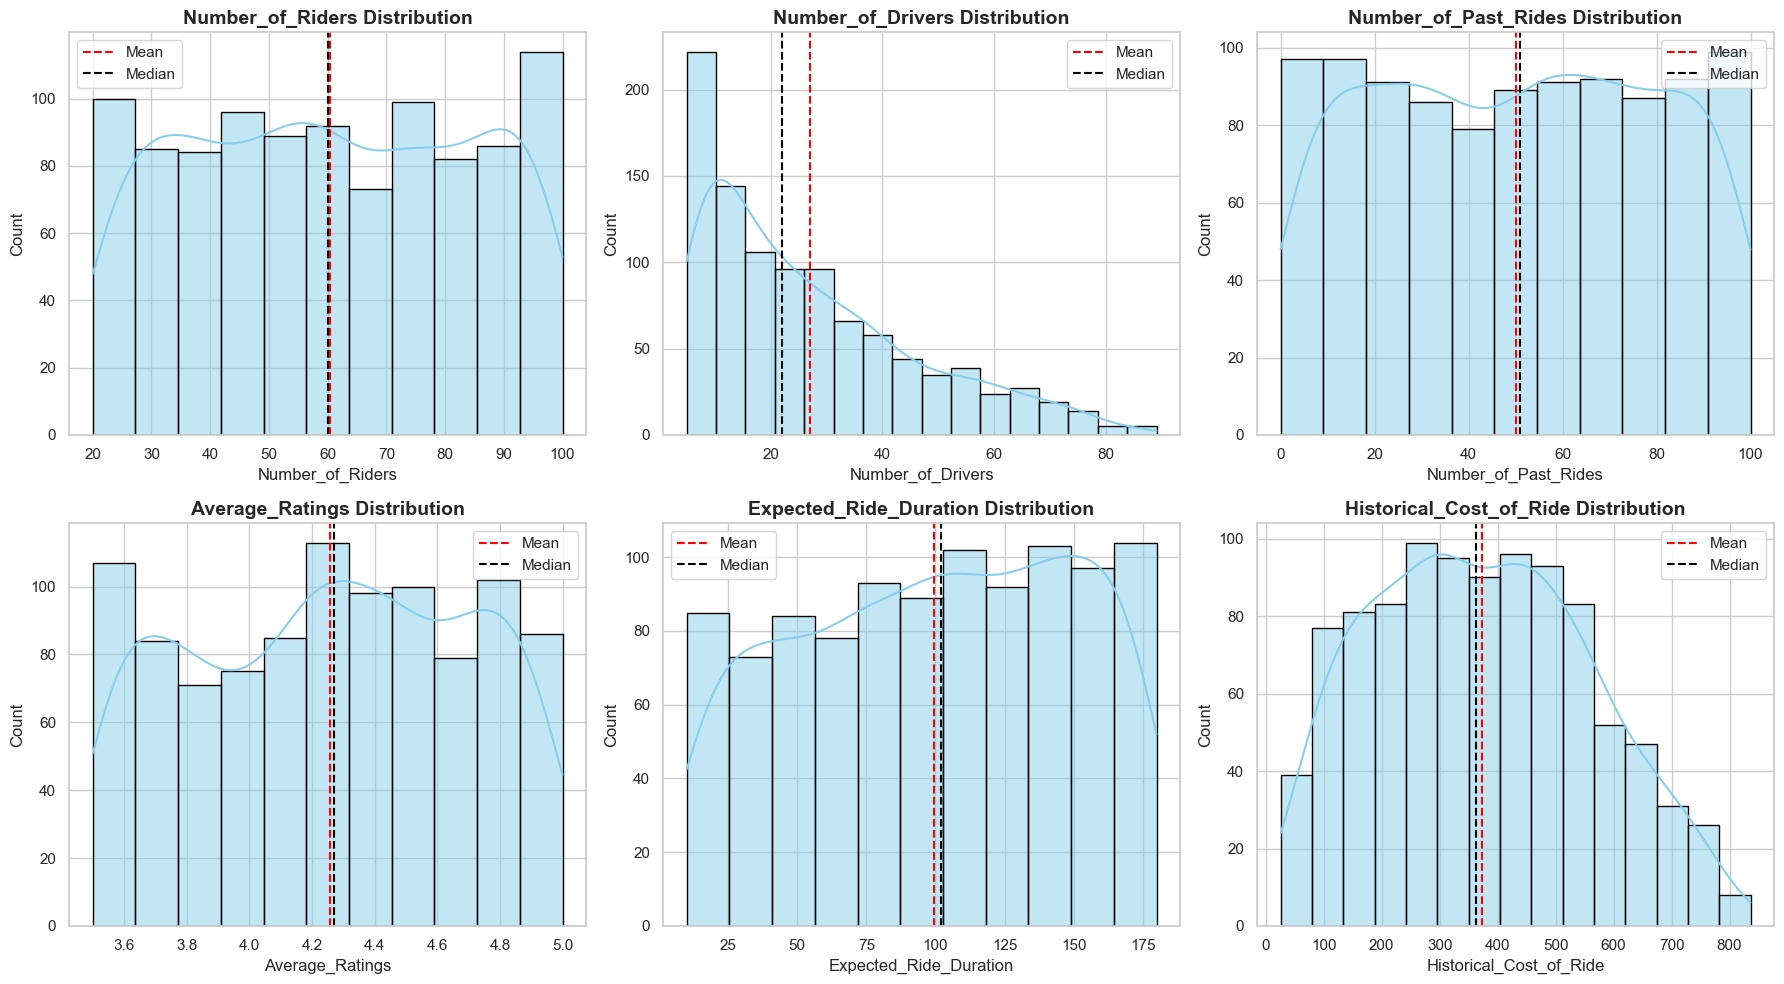

In [24]:
# Set figure size based on number of plots
num_cols = num.columns
n = len(num_cols)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue', edgecolor='black')

    # Add mean and median lines
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[i].axvline(mean_val, color='red', linestyle='--', label='Mean')
    axes[i].axvline(median_val, color='black', linestyle='--', label='Median')

    axes[i].set_title(f"{col} Distribution", fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel('Count')
    axes[i].legend()

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

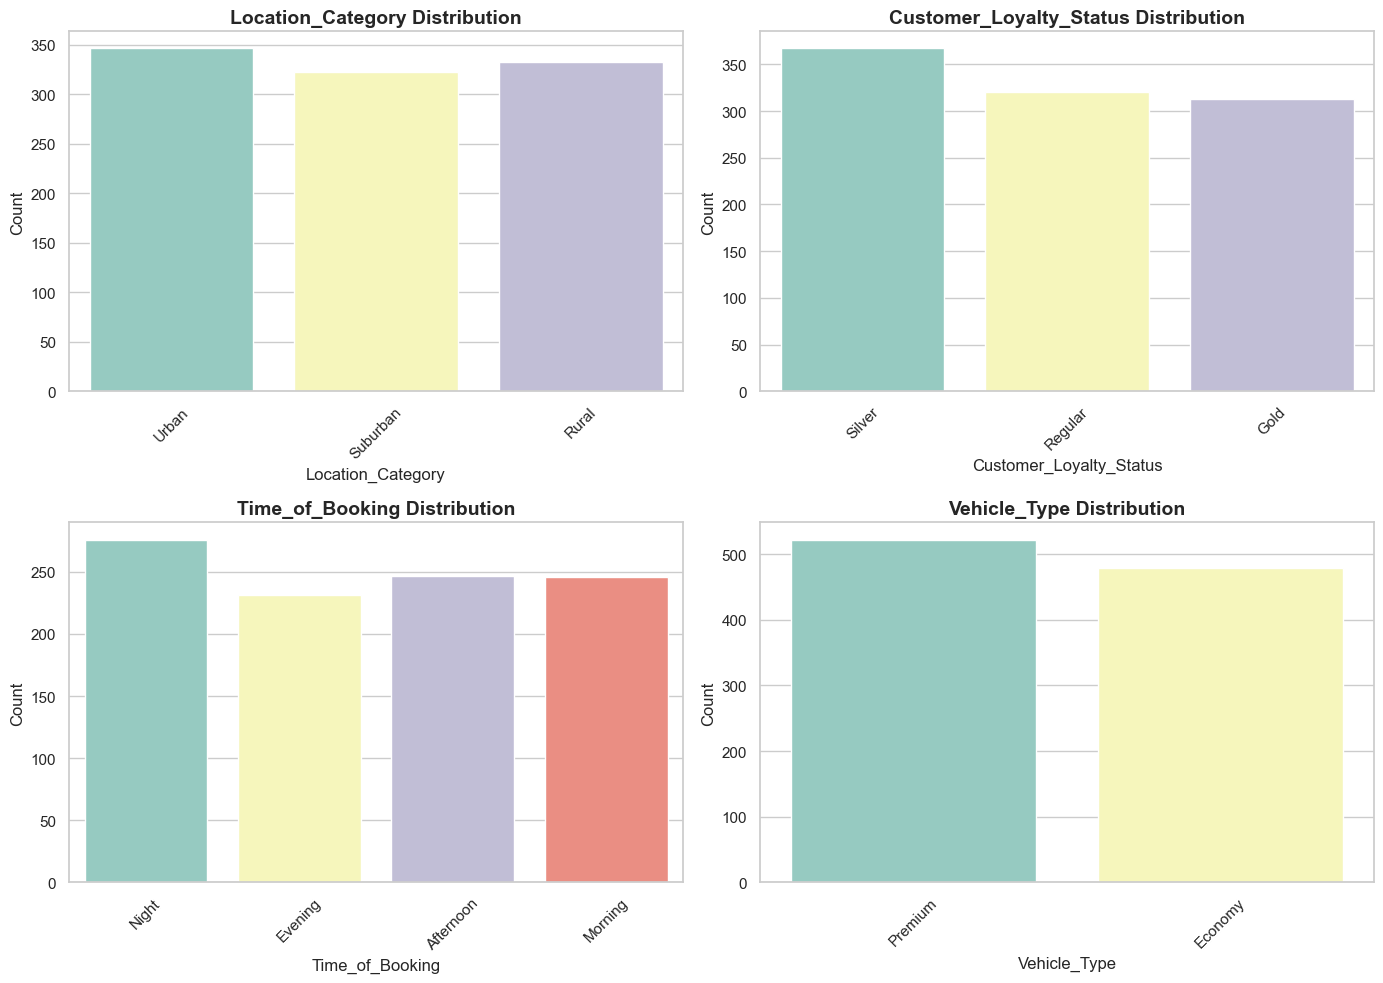

In [25]:
cat = df.select_dtypes(include='object')

# Get number of plots needed
cat_cols = cat.columns
n = len(cat_cols)
cols = 2  # Set columns per row
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

# Plot bar charts
for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, palette='Set3', ax=axes[i])
    axes[i].set_title(f"{col} Distribution", fontsize=14, fontweight='bold')
    axes[i].set_xlabel(col, fontsize=12)
    axes[i].set_ylabel("Count")

    # Rotate x-labels if too crowded
    axes[i].tick_params(axis='x', rotation=45)

# Remove extra subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import numpy as np

# Set style
sns.set(style="whitegrid")

# Select numeric columns
num = df.select_dtypes(include=['int64', 'float64'])

# Compute z-scores
z_scores = num.apply(zscore)

# Set threshold
threshold = 3

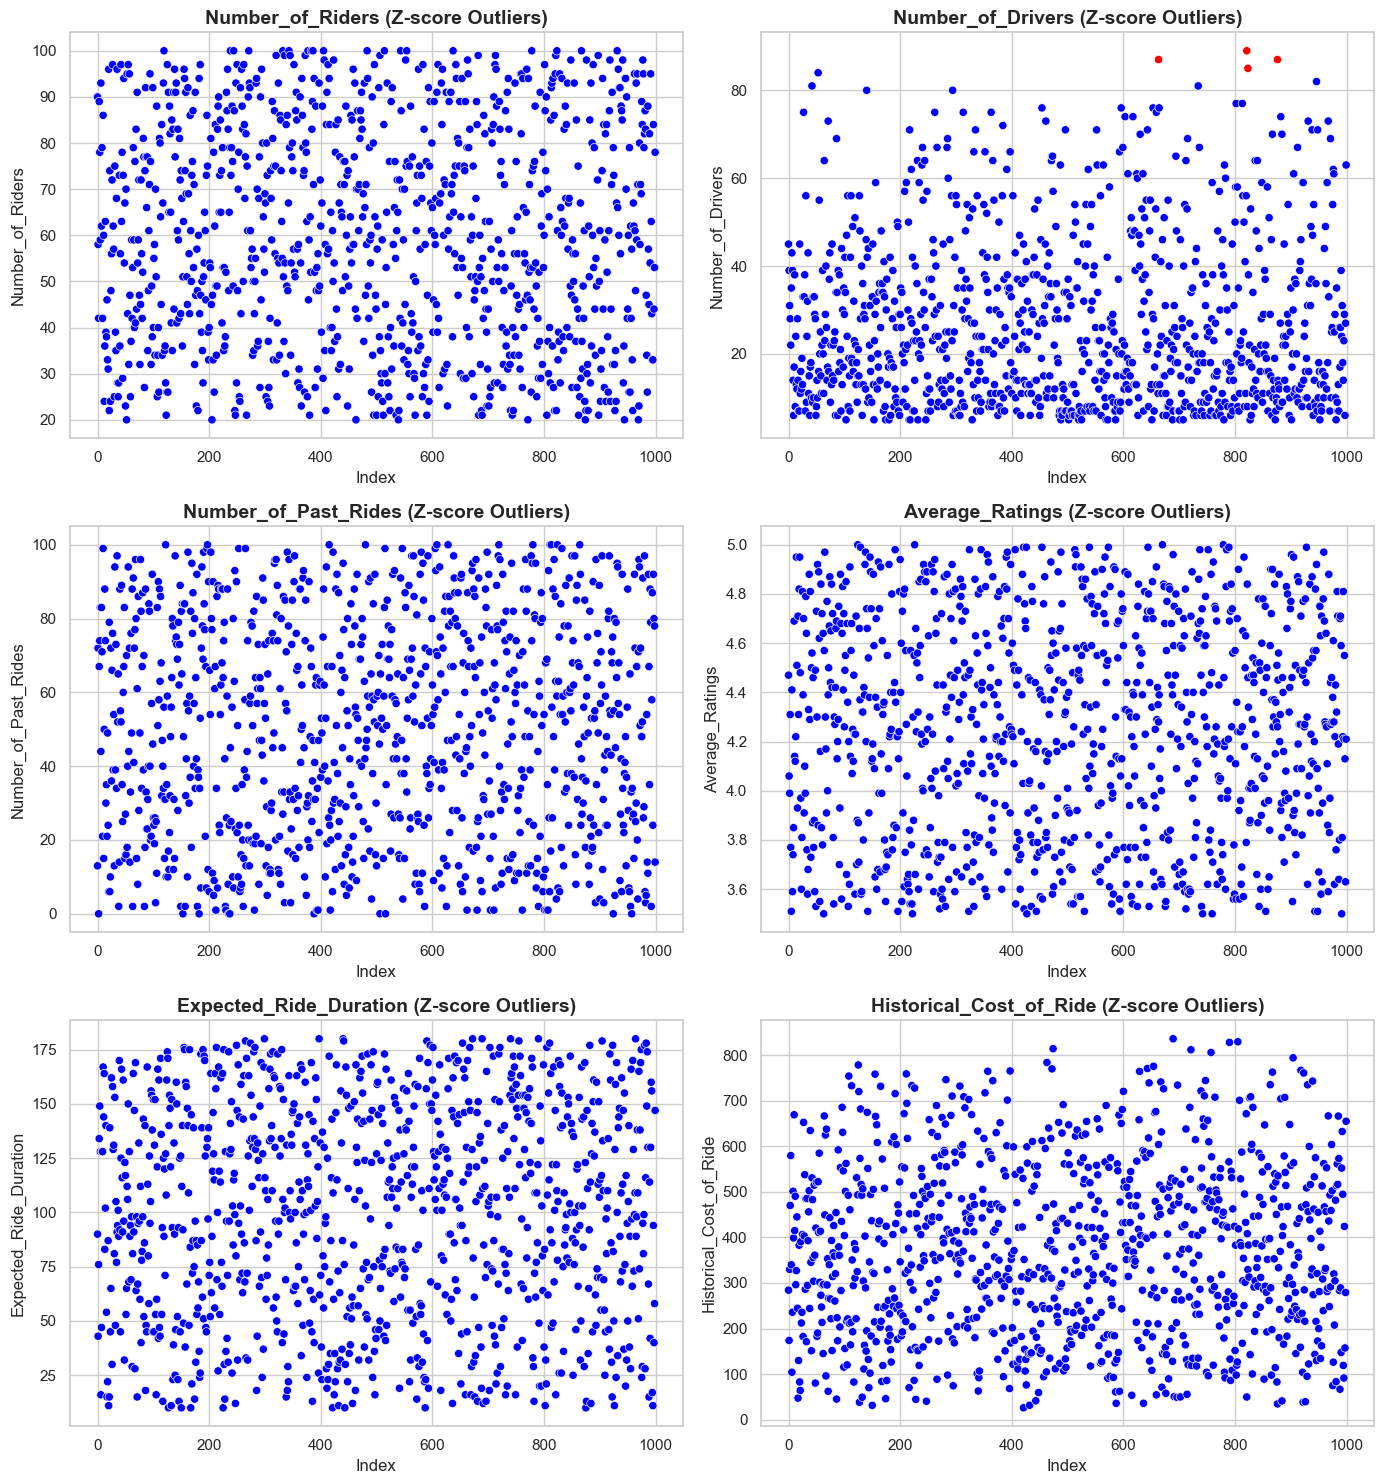

In [27]:
# Layout setup
cols = 2
rows = (len(num.columns) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
axes = axes.flatten()

# Plotting
for i, col in enumerate(num.columns):
    outliers = np.abs(z_scores[col]) > threshold
    sns.scatterplot(x=df.index, y=num[col], ax=axes[i], hue=outliers, palette={True: 'red', False: 'blue'}, legend=False)
    axes[i].set_title(f"{col} (Z-score Outliers)", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("Index")
    axes[i].set_ylabel(col)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# only the  'no.of drivers' column have outliers


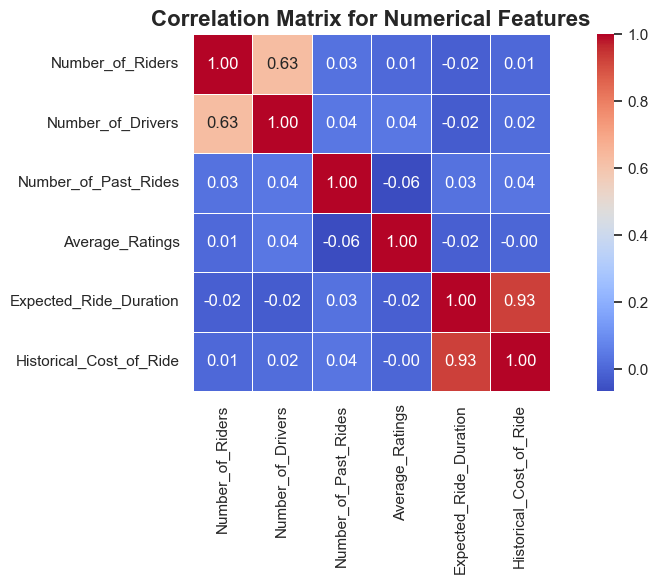

In [28]:
# Compute correlation matrix
corr_matrix = num.corr()

# Display the matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Correlation Matrix for Numerical Features", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

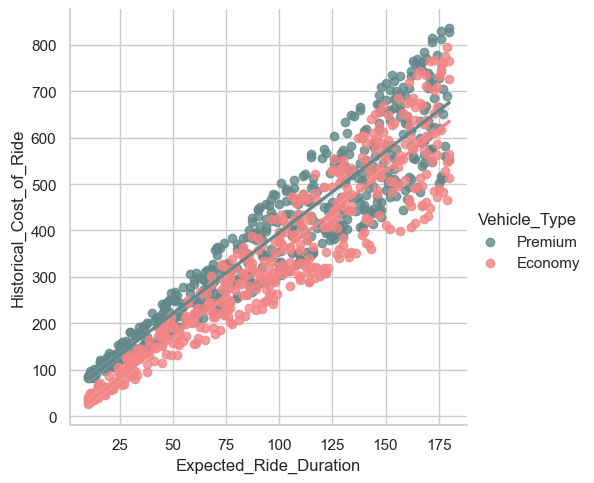

In [29]:
sns.lmplot(data=df, y='Historical_Cost_of_Ride', x='Expected_Ride_Duration', hue='Vehicle_Type', 
           palette=['#638889', '#f28585'])

# Show the plot
plt.show()

In [30]:
high_demand_percentile = 75
low_demand_percentile = 25

df['demand_multiplier'] = np.where(df['Number_of_Riders'] > np.percentile(df['Number_of_Riders'], high_demand_percentile),
                                    df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], high_demand_percentile),
                                    df['Number_of_Riders'] / np.percentile(df['Number_of_Riders'], low_demand_percentile) )
                
df['demand_multiplier']                  

0      1.111111
1      1.450000
2      1.050000
3      1.098765
4      1.950000
         ...   
995    0.825000
996    1.037037
997    1.100000
998    1.325000
999    1.950000
Name: demand_multiplier, Length: 1000, dtype: float64

In [31]:

high_supply_percentile = 75
low_supply_percentile = 25

df['supply_multiplier'] = np.where(df['Number_of_Drivers'] > np.percentile(df['Number_of_Drivers'],low_supply_percentile),
                                   np.percentile(df['Number_of_Drivers'], high_supply_percentile)/ df['Number_of_Drivers'], 
                                   np.percentile(df['Number_of_Drivers'],low_supply_percentile)/ df['Number_of_Drivers'])

df['supply_multiplier']

0      0.844444
1      0.974359
2      1.225806
3      1.357143
4      1.727273
         ...   
995    1.652174
996    1.310345
997    1.833333
998    1.407407
999    0.603175
Name: supply_multiplier, Length: 1000, dtype: float64

In [32]:
demand_threshold_high = 1.2  
demand_threshold_low = 0.8  
supply_threshold_high = 0.8  
supply_threshold_low = 1.2

In [33]:
df['adjusted_ride_cost'] = df['Historical_Cost_of_Ride'] * ( np.maximum(df['demand_multiplier'], demand_threshold_low) *
np.maximum(df['supply_multiplier'], supply_threshold_high) )

In [34]:
df['adjusted_ride_cost'] 

0       266.710528
1       245.653817
2       424.478684
3       701.155452
4      1952.472427
          ...     
995     124.567897
996     576.375440
997     317.352408
998     520.460581
999    1021.901565
Name: adjusted_ride_cost, Length: 1000, dtype: float64

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
 10  demand_multiplier        1000 non-null   float64
 11  supply_multiplier        1000 non-null   float64
 12  adjusted_ride_cost       1000 non-null   float64
dtypes: float64(5), int64(4), object(4)
memory usage: 101.7+ KB


### profit percentage

In [37]:
df['profit_percentage'] = ((df['adjusted_ride_cost'] - df['Historical_Cost_of_Ride']) / df['Historical_Cost_of_Ride']) * 100

In [38]:
profitable_rides = df[df['profit_percentage'] > 0]
loss_rides = df[df['profit_percentage'] < 0]


In [39]:
# Calculate the count of profitable and loss rides
profitable_count = len(profitable_rides)
loss_count = len(loss_rides)

Text(0.5, 1.0, 'Profitability of Rides (Dynamic Pricing vs. Historical Pricing)')

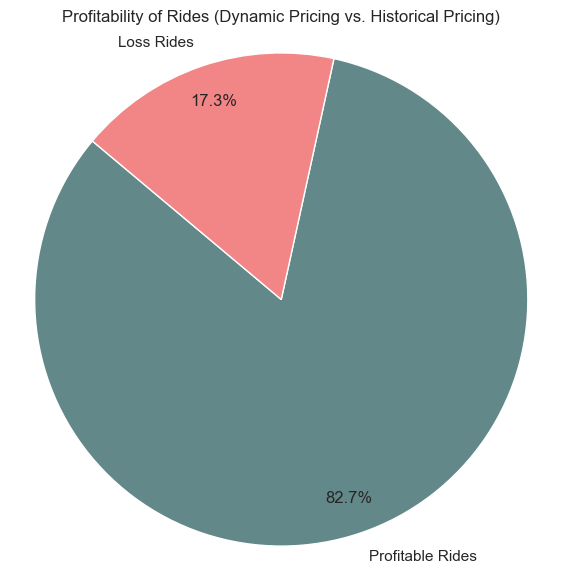

In [40]:
# Create a donut chart to show the distribution of profitable and loss rides
labels = ['Profitable Rides', 'Loss Rides']
values = [profitable_count, loss_count]

plt.figure(figsize=(7, 7))
# Create a pie chart
plt.pie(values,labels=labels,autopct='%1.1f%%',startangle=140,colors = ['#638889', '#f28585'], labeldistance = 1.1,pctdistance = 0.85, normalize=True)
plt.axis('equal')
plt.title('Profitability of Rides (Dynamic Pricing vs. Historical Pricing)')


 #### Transformation of Target Variable

 ##### log transformation

In [42]:
# adjusted_ride_cost is transformed using the natural logarithm plus one transformation (np.log1p). \

In [43]:
# Calculate the skewness of the target variable 'TARGET' 
print("Skewness: ", round(df['adjusted_ride_cost'].skew(), 2))

Skewness:  1.58


In [44]:
plt.figure(figsize=(8, 6))

mean_values = df['adjusted_ride_cost'].mean()
median = df['adjusted_ride_cost'].median()

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='adjusted_ride_cost', ylabel='Count'>

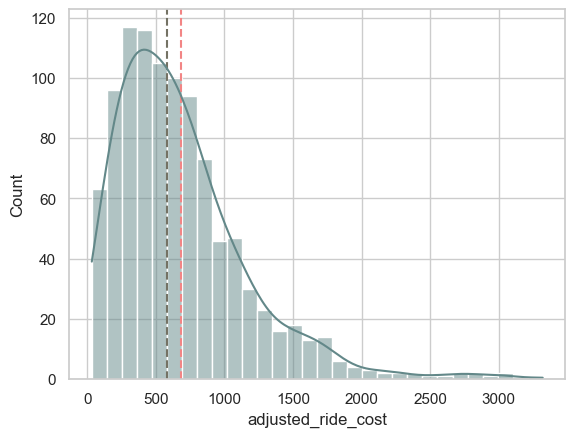

In [45]:
plt.axvline(x=mean_values, color='#F28585', linestyle='--', label='Mean')
plt.axvline(x=median, color='#747264', linestyle='--', label='Median')
sns.histplot(df['adjusted_ride_cost'], kde=True, color='#638889')

In [46]:
df['adjusted_ride_cost']=np.log1p( df['adjusted_ride_cost'] )

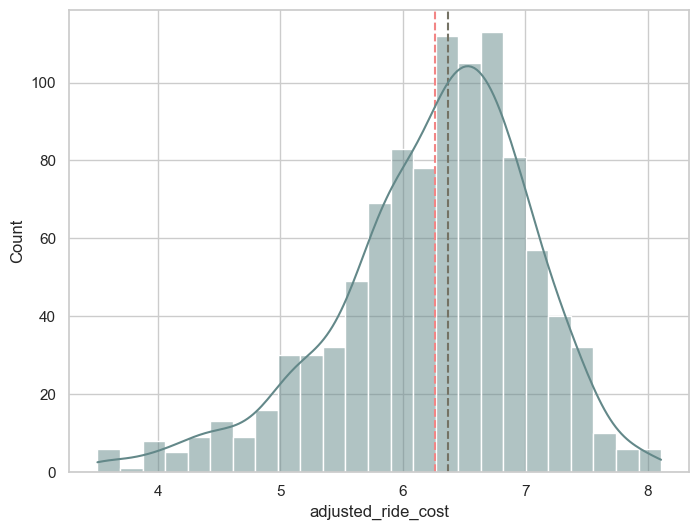

In [47]:
plt.figure(figsize=(8, 6))

mean_value = df['adjusted_ride_cost'].mean()
median = df['adjusted_ride_cost'].median()

plt.axvline(x=mean_value, color='#F28585', linestyle='--', label='Mean')
plt.axvline(x=median, color='#747264', linestyle='--', label='Median')

sns.histplot(df['adjusted_ride_cost'], kde=True, color='#638889')

plt.grid(True)

plt.show()

In [48]:
# Calculate the skewness of the transformed target variable 'TARGET'
print("Skewness: ", round(df['adjusted_ride_cost'].skew(), 2))
# now the skweness is reduced

Skewness:  -0.72


##### Box cox Transformation for Skewed Features


In [50]:
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p
print("Skewness: ", round(df['Number_of_Drivers'].skew(), 2))

Skewness:  0.96


In [51]:
lambda_est = boxcox_normmax(df['Number_of_Drivers'] + 2, brack=(-1.5, 1.5))
# Adds +2 to ensure all values are positive (Box-Cox only works with positive numbers).
# Searches for lambda in the range -1.5 to 1.5.
df['Number_of_Drivers'] = boxcox1p(df['Number_of_Drivers'], lambda_est)

print("Skewness: ", round(df['Number_of_Drivers'].skew(), 2))

Skewness:  -0.01


#### Data splitting

In [53]:
TARGET = df['adjusted_ride_cost']
df = df.drop(columns=['adjusted_ride_cost'])

In [54]:
# Count the number of columns for each data type and display the counts
df.dtypes.value_counts()

float64    6
object     4
int64      3
Name: count, dtype: int64

In [55]:
df['Vehicle_Type'] = df['Vehicle_Type'].map({'Economy': 0, 'Premium': 1})

In [56]:
# selects 4 features from the dataset and stores them in a new DataFrame X for training.
X = df[['Number_of_Riders', 'Number_of_Drivers', 'Expected_Ride_Duration', 'Vehicle_Type']]

# Fit a polynomial to the dataset
coefficients = np.polyfit(X['Number_of_Riders'].values, X['Number_of_Drivers'].values, deg=2)
print(coefficients)

[-1.30808014e-04  3.69368088e-02  1.65702871e+00]


In [57]:
# Create a polynomial based on the coefficients
poly = np.poly1d(coefficients)


# Calculate polynomial values for a new feature
division_feature = poly(X['Number_of_Riders'].values / X['Number_of_Drivers'].values)
print(division_feature)

[2.39194714 2.16357628 2.05424379 2.48280089 2.44239352 2.1873277
 2.42319957 2.19649599 2.5717989  2.36406703 2.58457132 2.18377066
 2.02673747 2.02679737 2.42133857 2.15994174 2.02878217 2.2136194
 2.18622059 2.1558551  2.436626   1.95694112 2.48311957 1.97288392
 2.18055322 2.34294542 2.30649229 2.35249595 2.22184202 2.15884358
 2.06343726 2.24434343 2.21698434 2.01690762 2.27814742 2.44570137
 2.03555637 1.96035724 2.1407858  2.45738946 2.06226753 2.40994846
 2.34030002 2.52797117 2.35642263 2.06290857 2.31485879 2.5161524
 2.17676064 2.73194614 2.01189698 2.47752002 1.94061826 2.32172122
 2.15615013 2.40570834 2.00668566 2.56112463 2.21177597 1.99641905
 2.04707182 2.17183058 2.11079343 2.34845469 2.25372987 2.25586995
 2.04352982 2.30529429 2.06586044 2.61288055 2.15695513 2.31674659
 2.27532311 2.17926993 2.26181357 2.32349117 1.99620886 2.21645778
 2.25467378 2.31044399 2.09735805 2.28129777 2.45919774 2.40454546
 2.12436272 2.31776217 2.33233513 2.34251604 2.71799005 2.3176297

In [58]:
X['interpolated_division'] = pd.Series(division_feature)
# Stores the new transformed feature into the dataset (X) as a new column called 'interpolated_division'.

#### scaling

In [60]:
from sklearn.preprocessing import StandardScaler
y = TARGET
scaler = StandardScaler()

X_scaled=scaler.fit_transform(X)

In [61]:
with open('scaler.pkl', 'wb') as file:
    dill.dump(scaler, file)

In [62]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

#### Model training

In [64]:
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(objective='reg:squarederror'),
    'CatBoostRegressor': CatBoostRegressor(verbose=0)
}


In [65]:
params = {
    'Ridge': {'model__alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'model__alpha': [0.001, 0.01, 0.1]},
    'ElasticNet': {'model__alpha': [0.001, 0.01, 0.1], 'model__l1_ratio': [0.2, 0.5, 0.8]},
    'SVR': {'model__C': [0.1, 1, 10], 'model__epsilon': [0.1, 0.2, 0.5], 'model__kernel': ['linear', 'rbf']},
    'RandomForestRegressor': {'model__n_estimators': [10, 50, 100]},
    'XGBRegressor': {'model__learning_rate': [0.1, 0.5], 'model__max_depth': [3, 5, 7]},
    'CatBoostRegressor': {'model__learning_rate': [0.01, 0.1, 0.5], 'model__depth': [4, 6, 8]}
}

In [66]:
# user defined function to create RMSE
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)
rmse_scorer
# Create a custom scorer 'rmse_scorer' using make_scorer
# 'greater_is_better=False' indicates that lower values of the scoring function are better

make_scorer(rmse, greater_is_better=False, response_method='predict')

In [67]:

# Initialize an empty list to store the results
results = []

# Initialize variables to track the best model and its R-squared score
best_model = None
best_r2 = float('-inf')

# Iterate over each model in the models dictionary
for name, model in models.items():
    # Create a pipeline with the model
    pipeline = Pipeline([
        ('model', model)
    ])
    
    # Check if hyperparameters for the current model are defined in the params dictionary
    if name in params:
        # If hyperparameters are defined, perform grid search with cross-validation
        grid_search = GridSearchCV(pipeline, params[name], cv=5, scoring=rmse_scorer)
    else:
        # If hyperparameters are not defined, perform grid search with default hyperparameters
        grid_search = GridSearchCV(pipeline, {}, cv=5, scoring=rmse_scorer)
    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = grid_search.predict(X_test)
        # Calculate R-squared score and RMSE on the test set
    r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))
    rmse_val = rmse(np.expm1(y_test), np.expm1(y_pred))


    # Update the best model and its R-squared score if the current model performs better
    if r2 > best_r2:
        best_r2 = r2
        best_model = grid_search
    
    # Append the results to the results list
    results.append({
        'Model': name,
        'R-Squared Score': r2,
        'RMSE Score': rmse_val,
        'Best Parameters': grid_search.best_params_
    })


# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

NameError: name 'Pipeline' is not defined

#### Model Evaluation on Test Set


In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.5f}'.format)
results_df.info()
results_df

In [ ]:
y_pred = best_model.predict(X_test)
# Calculate the R-squared (R2) score using the predictions and true target values
# Used to undo a previous log transformation on the target variable.
r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))

print(f"R-squared (R2): {r2}")

### Residual plots

In [ ]:
# Calculate residuals
residuals = np.expm1(y_test) - np.expm1(y_pred)

# Calculate standard deviation of residuals
sigma = np.std(residuals)

# Create a list for hue parameter
hue = list(map(lambda x: abs(x) < sigma, residuals))


In [ ]:
# Create a residual plot
plt.figure(figsize=(5, 5))
sns.scatterplot(x=y_pred, y=residuals, hue=hue, palette = ['#f28585', '#638889'], s=100)
plt.axhline(y=0, color='#A79277', linestyle='--', lw=1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

#### Hyperparameter Tuning

In [ ]:
# Create a CatBoostRegressor model with specified hyperparameters
model = CatBoostRegressor(verbose=0, subsample=0.9, learning_rate=0.05000000000000001, l2_leaf_reg=2,
                          iterations=350, depth=4)

# Fit the model to the training data
model.fit(X_train, y_train)

# Extract feature importances from the trained model
feature_coefficients = pd.DataFrame(model.feature_importances_, index=X.columns,
                                    columns=['Importance']).sort_values(by='Importance', ascending=False)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the R-squared (R2) score using the predictions and true target values
r2 = r2_score(np.expm1(y_test), np.expm1(y_pred))

# Print the R-squared (R2) score
print(f"R-squared (R2): {r2}")

In [ ]:
# Fit the model to the training data and evaluate it on the test set
# use_best_model=True ensures that the model uses the best iteration based on early stopping
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# Get the RMSE values during training from the evaluation set
train_log_loss = model.get_evals_result()['validation']['RMSE']

# Plot RMSE over iterations
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(train_log_loss) + 1), train_log_loss, label='Validation RMSE', color='#638889')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Validation RMSE Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# Create a normal pie chart
plt.pie(
    feature_coefficients['Importance'].values,
    labels=feature_coefficients.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=['#638889', '#868788', '#aa8687', '#ce8586', '#f28585'],
    labeldistance=1.1,
    pctdistance=0.85,
    normalize=True
)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

plt.show()


### Prediction 

In [ ]:
# Function to map vehicle type to numeric value
def get_vehicle_type_numeric(vehicle_type):
    # Define a mapping from vehicle type to numeric value
    vehicle_type_mapping = {
        "Premium": 1,
        "Economy": 0
    }
    # Get the numeric value for the given vehicle type
    vehicle_type_numeric = vehicle_type_mapping.get(vehicle_type)
    return vehicle_type_numeric

In [ ]:
# Predicting price using user input values
def predict_price(number_of_riders, number_of_drivers, Expected_Ride_Duration, vehicle_type):
    # Convert vehicle type to numeric representation
    vehicle_type_numeric = get_vehicle_type_numeric(vehicle_type)
    # Raise error if vehicle type is invalid
    if vehicle_type_numeric is None:
        raise ValueError("Invalid vehicle type")
    
    # Convert lists to numpy arrays for numerical computation
    number_of_riders = np.array(number_of_riders)
    number_of_drivers = np.array(number_of_drivers)
    
    # Fit a polynomial regression model to the data
    coefficients = np.polyfit(number_of_riders.ravel(), number_of_drivers.ravel(), deg=2)
    poly = np.poly1d(coefficients)
    
    # Calculate division feature
    division_feature = poly(number_of_riders / number_of_drivers)
    
    # Create input data array for prediction
    input_data = np.array([number_of_riders, number_of_drivers, Expected_Ride_Duration, vehicle_type_numeric, division_feature])

    # Reshape input data for compatibility with the model
    input = pd.DataFrame(input_data.reshape(1, -1))
    
    # Scale input data using scaler object
    scaled_input_data = scaler.transform(input)
    
    # Make price prediction using the model
    predicted_price = model.predict(scaled_input_data)
    return predicted_price
        # Reshape input data for compatibility with the model
    input = pd.DataFrame(input_data.reshape(1, -1))
    
    # Scale input data using scaler object
    scaled_input_data = scaler.transform(input)
    
    # Make price prediction using the model
    predicted_price = model.predict(scaled_input_data)
    return predicted_price
    


In [ ]:
 # Example prediction using user input values
user_number_of_riders = 42
user_number_of_drivers = 31
user_vehicle_type = "Premium"
Expected_Ride_Duration = 76
predicted_price = predict_price(user_number_of_riders, user_number_of_drivers, Expected_Ride_Duration, user_vehicle_type)

# Print the predicted price
print("Predicted price:", np.expm1(predicted_price))



In [ ]:
## save the model
with open('workbook_predict.pkl', 'wb') as file:
    dill.dump(model, file)

In [ ]:
!pip freeze > requirements.txt

In [ ]:
import pickle

In [ ]:
with open('workbook_predict.pkl', 'rb') as file:
    data = pickle.load(file)

In [ ]:
## unpackin gof the pkl file
import pickle

# Replace 'path_to_your_file.pkl' with the actual path to your PKL file
file_path = 'workbook_predict.pkl'

# Open the file in binary mode and load the data
with open('workbook_predict.pkl', 'rb') as file:
    data = pickle.load(file)

# Now 'data' contains the deserialized Python object
print(data)